# Load data from YelpZip

In [14]:
import pandas as pd

In [15]:
metad = pd.read_csv('metadata', delimiter='\t', names=['user_id','prod_id','rating','label','date'], index_col = None)
review = pd.read_csv('reviewContent', delimiter='\t', names=['user_id','prod_id','date','review'], index_col = None)

data = pd.merge(metad, review, on=['user_id','prod_id','date'], how='inner')

label_mapping = {-1: 0, 1: 1} #0 for fake, 1 for genuine
data['label'] = data['label'].map(label_mapping)


In [16]:
data

,user_id,prod_id,rating,label,date,review
0,5044,0,1.0,0,2014-11-16,"Drinks were bad, the hot chocolate was watered..."
1,5045,0,1.0,0,2014-09-08,This was the worst experience I've ever had a ...
2,5046,0,3.0,0,2013-10-06,This is located on the site of the old Spruce ...
3,5047,0,5.0,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...
4,5048,0,5.0,0,2014-08-28,I love Toast! The food choices are fantastic -...
...,...,...,...,...,...,...
608453,119664,5039,4.0,1,2013-01-20,When I first moved to the area I must say I wa...
608454,56277,5039,2.0,1,2012-11-12,Kind of pricey. I guess I expected a ridiculou...
608455,265320,5039,1.0,1,2012-08-22,"Stopped by this restaurant yesterday, we just ..."
608456,161722,5039,4.0,1,2011-05-11,Finally checked out The Best Subs in Claremont...


In [17]:
label_counts = data['label'].value_counts()

print(label_counts)

1    528019
0     80439
Name: label, dtype: int64


In [18]:
sample_size = 5000

In [19]:
# data for training
label_counts = data['label'].value_counts()

# 计算各标签应该采样的数量
sample_size_true = int(sample_size / 2)
sample_size_false =int(sample_size / 2)


# 按标签分组并进行分层抽样
stratified_sample = data.groupby('label').apply(lambda x: x.sample(n=sample_size_true if x.name == 1 else sample_size_false))

# 重置索引
stratified_sample = stratified_sample.reset_index(drop=True)
df_selected = stratified_sample.copy()

# 找出未被选中的数据
data['selected'] = data.index.isin(df_selected.index)
df_unselected = data[data['selected'] == False].drop(columns='selected')

data = df_selected
# Here, df_selected contains the data selected and put into the datafile, while df_unselected contains the remaining

In [20]:
# data_test for testing
label_counts = df_unselected['label'].value_counts()

# 计算各标签应该采样的数量
sample_size = sample_size * 0.2
sample_size_true = int(sample_size / 2)
sample_size_false =int(sample_size / 2)


# 按标签分组并进行分层抽样
stratified_sample = df_unselected.groupby('label').apply(lambda x: x.sample(n=sample_size_true if x.name == 1 else sample_size_false))

# 重置索引
stratified_sample = stratified_sample.reset_index(drop=True)
df_selected = stratified_sample.copy()

# 找出未被选中的数据
data['selected'] = data.index.isin(df_selected.index)
df_unselected = data[data['selected'] == False].drop(columns='selected')

data_test = df_selected
# Here, df_selected contains the data selected and put into the datafile, while df_unselected contains the remaining

# BERT Model

1. Load necceary packages

In [21]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


2. Read and preprocess data

In [22]:
class FakeReviewDataset(Dataset):

    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = str(self.reviews[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 256

df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

train_dataset = FakeReviewDataset(df_train['review'].to_numpy(), df_train['label'].to_numpy(), tokenizer, max_length)
val_dataset = FakeReviewDataset(df_val['review'].to_numpy(), df_val['label'].to_numpy(), tokenizer, max_length)
test_dataset = FakeReviewDataset(df_test['review'].to_numpy(), df_test['label'].to_numpy(), tokenizer, max_length)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


3. Modelling

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
num_epochs = 4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

4. Build the helper function

In [24]:
from tqdm import tqdm

def train_eval_model(model, dataloader, optimizer=None, is_training=True):
    if is_training:
        model.train()
    else:
        model.eval()

    total_accuracy = 0
    total_loss = 0

    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        total_loss += loss.item()

        if is_training:
            optimizer.zero_grad
            loss.backward()
            optimizer.step()

        _, preds = torch.max(logits, dim=1)
        total_accuracy += torch.sum(preds == labels)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)

    return avg_loss, avg_accuracy


5. Test and evaluate the model

In [25]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print('-' * 10)

    train_loss, train_accuracy = train_eval_model(model, train_dataloader, optimizer, is_training=True)
    print(f"Train loss: {train_loss}, Train accuracy: {train_accuracy}")

    val_loss, val_accuracy = train_eval_model(model, val_dataloader, is_training=False)
    print(f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")


Epoch 1/4
----------


  8%|▊         | 21/250 [11:29<2:05:16, 32.82s/it]


KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = train_eval_model(model, test_dataloader, is_training=False)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


6. Save the model

In [ ]:
model.save_pretrained("fake_review_detector")
tokenizer.save_pretrained("fake_review_detector")


7. Reuse the model

In [ ]:
# from transformers import BertForSequenceClassification, BertTokenizer, pipeline

# model = BertForSequenceClassification.from_pretrained("fake_review_detector")
# tokenizer = BertTokenizer.from_pretrained("fake_review_detector")
# review_detector = pipeline("text-classification", model=model, tokenizer=tokenizer)


In [ ]:
# text = "Your specific text for classification goes here."
# result = review_detector(text)


# Evaluating the model

In [ ]:
import numpy as np
import pandas as pd
from transformers import BertForSequenceClassification, BertTokenizer, pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


In [ ]:
# model = BertForSequenceClassification.from_pretrained("fake_review_detector")
# tokenizer = BertTokenizer.from_pretrained("fake_review_detector")


In [ ]:
def detect_reviews(reviews):
    review_classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    results = outputs.logits.detach().numpy()
    return np.argmax(results, axis=1)


In [ ]:
reviews_test = data_test["review"].tolist()
labels_test = data_test["label"].tolist()  # Assuming label 0 is "FAKE" and label 1 is "REAL"

predicted_labels = detect_reviews(reviews_test)



In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(labels_test, predicted_labels)
print("Confusion Matrix:\n", conf_mat)

# Classification Report
class_report = classification_report(labels_test, predicted_labels, target_names=["FAKE", "REAL"])
print("\nClassification Report:\n", class_report)

# Accuracy Score
acc_score = accuracy_score(labels_test, predicted_labels)
print("\nAccuracy Score:", acc_score)

# Precision Score
prec_score = precision_score(labels_test, predicted_labels)
print("\nPrecision Score:", prec_score)

# Recall
recall = recall_score(labels_test, predicted_labels)
print("\nRecall:", recall)

# F1 Score
f1 = f1_score(labels_test, predicted_labels)
print("\nF1 Score:", f1)

# ROC AUC
roc_auc = roc_auc_score(labels_test, predicted_labels)
print("\nROC AUC:", roc_auc)


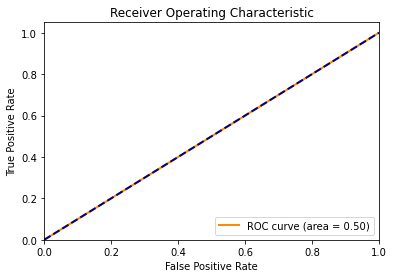

In [13]:
fpr, tpr, _ = roc_curve(labels_test, predicted_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# OpenAI documentation

GPT-3 fine tuning
https://platform.openai.com/docs/guides/fine-tuning

GPT-3 classification
https://platform.openai.com/examples/default-classification

GPT-3 model family
https://platform.openai.com/docs/models/gpt-3

GPT-2 based classification (deprecated)
https://platform.openai.com/docs/guides/classifications